# Leash Tutorial - ECFPs and Random Forest
## Introduction

There are many ways to represent molecules for machine learning.

In this tutorial we will go through one of the simplest: ECFPs [[1]](https://pubs.acs.org/doi/10.1021/ci100050t) and Random Forest. This technique is surprisingly powerful, and on previous benchmarks often gets uncomfortably close to the state of the art.

First molecule graphs are broken into bags of subgraphs of varying sizes.

![ecfp featurizing process (chemaxon)](https://docs.chemaxon.com/display/docs/images/download/attachments/1806333/ecfp_generation.png)

Then the bag of subgraphs is hashed into a bit vector

![hashing process (chemaxon)](https://docs.chemaxon.com/display/docs/images/download/attachments/1806333/ecfp_folding.png)

This can be thought of as analogous to the [hashing trick](https://en.wikipedia.org/wiki/Feature_hashing) [[2]](https://alex.smola.org/papers/2009/Weinbergeretal09.pdf) on bag of words for NLP problems, from the days before transformers.

RDKit, an open-source cheminformatics tool, is used for generating ECFP features. It facilitates the creation of hashed bit vectors, streamlining the process. We can install it as follows:

In [1]:
!pip install rdkit

The training set is pretty big, but we can treat the parquet files as databases using duckdb. We will use this to sample down to a smaller dataset for demonstration purposes. Lets install duckdb as well.

In [5]:
!pip install duckdb
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 2.1 MB/s  0:00:06m0:00:0100:01


## Data Preparation

The training and testing data paths are defined for the .parquet files. We use duckdb to scan search through the large training sets. Just to get started lets sample out an equal number of positive and negatives.

This query selects an equal number of samples where binds equals 0 (non-binding) and 1 (binding), limited to 30,000 each, to avoid model bias towards a particular class.

In [6]:
import duckdb
import pandas as pd

train_path = './train.parquet'
test_path = './test.parquet'

con = duckdb.connect()

df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT 30000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT 30000)""").df()

con.close()

In [7]:
print(len(df))
n = duckdb.query("SELECT COUNT(*) FROM 'train.parquet'").fetchone()[0]
print(n)

60000
295246830


In [8]:
df.head()

id                              buildingblock1_smiles  \
0  258273961  O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...   
1   74622373     O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21   
2   21244588          CCCCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
3  247242260  O=C(O)C[C@@H](Cc1ccc(Cl)cc1)NC(=O)OCC1c2ccccc2...   
4   69762301  N#Cc1cccc(C[C@H](CC(=O)O)NC(=O)OCC2c3ccccc3-c3...   

            buildingblock2_smiles             buildingblock3_smiles  \
0                  CC1(C)CCOC1CCN  Nc1cccc2c1CN(C1CCC(=O)NC1=O)C2=O   
1           Cl.N#CC1(NC(=O)CN)CC1                     Nc1nccc(Cl)n1   
2            Cl.NCC(F)(F)C(F)(F)F                       NCc1ccsc1Br   
3                       Nc1cnccn1                   CCn1cc(N)c(C)n1   
4  CC(C)(C)OC(=O)n1ncc2cc(N)ccc21              Nc1ccc2c(c1)CC(=O)N2   

                                     molecule_smiles protein_name  binds  
0  CC1(C)CCOC1CCNc1nc(Nc2cccc3c2CN(C2CCC(=O)NC2=O...          HSA      0  
1  N#CC1(NC(=O)CNc2nc(Nc3nccc(Cl)n3)nc(NC(Cc3cccc...          HSA      0  
2  CCCCC(Nc1nc(NCc2ccsc2Br)nc(NCC(F)(F)C(F)(F)F)n...          HSA      0  
3  CCn1cc(Nc2nc(Nc3cnccn3)nc(N[C@@H](CC(=O)N[Dy])...          sEH      0  
4  CC(C)(C)OC(=O)n1ncc2cc(Nc3nc(Nc4ccc5c(c4)CC(=O...          HSA      0

## Feature Preprocessing

Lets grab the smiles for the fully assembled molecule `molecule_smiles` and generate ecfps for it. We could choose different radiuses or bits, but 2 and 1024 is pretty standard.

In [9]:
!pip install --upgrade scikit-learn
!python -c "import sklearn, sys; print('scikit-learn', sklearn.__version__)"

scikit-learn 1.7.2


In [10]:
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder

df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)

def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

df['ecfp'] = df['molecule'].apply(generate_ecfp)

[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerator
[16:49:57] DEPRECATION WARNING: please use MorganGenerat

## Train Model

In [ ]:
# One-hot encode the protein_name
onehot_encoder = OneHotEncoder(sparse_output=False)
protein_onehot = onehot_encoder.fit_transform(df['protein_name'].values.reshape(-1, 1))

# Combine ECFPs and one-hot encoded protein_name
X = [ecfp + protein for ecfp, protein in zip(df['ecfp'].tolist(), protein_onehot.tolist())]
y = df['binds'].tolist()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculate the mean average precision
map_score = average_precision_score(y_test, y_pred_proba)
print(f"Mean Average Precision (mAP): {map_score:.2f}")

Mean Average Precision (mAP): 0.96


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

gb_model = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=None,
    max_iter=500,
    random_state=42
)

gb_model.fit(X_train, y_train)

y_pred_proba = gb_model.predict_proba(X_test)[:, 1]
map_score = average_precision_score(y_test, y_pred_proba)
print(f"Mean Average Precision: {map_score:.2f}")

Mean Average Precision: 0.97


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(512, 256),
    activation="relu",
    solver="adam",
    batch_size=256,
    max_iter=20,
    random_state=42
)

mlp_model.fit(X_train, y_train)

y_pred_proba = mlp_model.predict_proba(X_test)[:, 1]
map_score = average_precision_score(y_test, y_pred_proba)
print(f"Mean Average Precision (MLP): {map_score:.2f}")

Mean Average Precision (MLP): 0.97


/Users/sofiiapopeniuk/miniconda3/envs/belka/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [23]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.2 MB/s  0:00:01 eta 0:00:01


In [24]:
from xgboost import XGBClassifier

X = np.array([ecfp + protein for ecfp, protein in zip(df["ecfp"].tolist(), protein_onehot.tolist())])
y = np.array(df["binds"].tolist())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

xgb_model.fit(X_train, y_train)

y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
map_score = average_precision_score(y_test, y_pred_proba)
print(f"Mean Average Precision (XGBoost): {map_score:.2f}")

Mean Average Precision (XGBoost): 0.95


Look at that Average Precision score. We did amazing!

Actually no, we just overfit. This is likely recurring theme for this competition. It is easy to predict molecules that come from the same corner of chemical space, but generalizing to new molecules is extremely difficult.

## Test Prediction

 The trained Random Forest model is then used to predict the binding probabilities. These predictions are saved to a CSV file, which serves as the submission file for the Kaggle competition.

In [ ]:
import os

# Process the test.parquet file chunk by chunk
test_file = './test.csv'
output_file = 'submission.csv'  # Specify the path and filename for the output file

# Read the test.parquet file into a pandas DataFrame
for df_test in pd.read_csv(test_file, chunksize=100000):

    # Generate ECFPs for the molecule_smiles
    df_test['molecule'] = df_test['molecule_smiles'].apply(Chem.MolFromSmiles)
    df_test['ecfp'] = df_test['molecule'].apply(generate_ecfp)

    # One-hot encode the protein_name
    protein_onehot = onehot_encoder.transform(df_test['protein_name'].values.reshape(-1, 1))

    # Combine ECFPs and one-hot encoded protein_name
    X_test = [ecfp + protein for ecfp, protein in zip(df_test['ecfp'].tolist(), protein_onehot.tolist())]

    # Predict the probabilities
    probabilities = rf_model.predict_proba(X_test)[:, 1]

    # Create a DataFrame with 'id' and 'probability' columns
    output_df = pd.DataFrame({'id': df_test['id'], 'binds': probabilities})

    # Save the output DataFrame to a CSV file
    output_df.to_csv(output_file, index=False, mode='a', header=not os.path.exists(output_file))


In [ ]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')

test_file = "./test.csv"
output_file = "submission2.csv"

if os.path.exists(output_file):
    os.remove(output_file)

for df_test in pd.read_csv(test_file, chunksize=100000):
    df_test["molecule"] = df_test["molecule_smiles"].apply(Chem.MolFromSmiles)
    df_test["ecfp"] = df_test["molecule"].apply(generate_ecfp)

    protein_onehot = onehot_encoder.transform(
        df_test["protein_name"].values.reshape(-1, 1)
    )

    X_test = np.array([
        ecfp + protein
        for ecfp, protein in zip(df_test["ecfp"].tolist(), protein_onehot.tolist())
    ])

    probabilities = gb_model.predict_proba(X_test)[:, 1]

    output_df = pd.DataFrame({"id": df_test["id"], "binds": probabilities})
    output_df.to_csv(
        output_file,
        index=False,
        mode="a",
        header=not os.path.exists(output_file)
    )

In [21]:
output_file = "submission3.csv"
for df_test in pd.read_csv(test_file, chunksize=100000):
    df_test["molecule"] = df_test["molecule_smiles"].apply(Chem.MolFromSmiles)
    df_test["ecfp"] = df_test["molecule"].apply(generate_ecfp)

    protein_onehot = onehot_encoder.transform(
        df_test["protein_name"].values.reshape(-1, 1)
    )

    X_test = np.array([
        ecfp + protein
        for ecfp, protein in zip(df_test["ecfp"].tolist(), protein_onehot.tolist())
    ])

    probabilities = mlp_model.predict_proba(X_test)[:, 1]

    output_df = pd.DataFrame({"id": df_test["id"], "binds": probabilities})
    output_df.to_csv(
        output_file,
        index=False,
        mode="a",
        header=not os.path.exists(output_file)
    )

In [25]:
output_file = "submission4.csv"

if os.path.exists(output_file):
    os.remove(output_file)

for df_test in pd.read_csv(test_file, chunksize=100000):
    df_test["molecule"] = df_test["molecule_smiles"].apply(Chem.MolFromSmiles)
    df_test["ecfp"] = df_test["molecule"].apply(generate_ecfp)

    protein_onehot_test = onehot_encoder.transform(
        df_test["protein_name"].values.reshape(-1, 1)
    )

    X_test_chunk = np.array([
        ecfp + protein
        for ecfp, protein in zip(df_test["ecfp"].tolist(), protein_onehot_test.tolist())
    ])

    probabilities = xgb_model.predict_proba(X_test_chunk)[:, 1]

    output_df = pd.DataFrame({"id": df_test["id"], "binds": probabilities})
    output_df.to_csv(
        output_file,
        index=False,
        mode="a",
        header=not os.path.exists(output_file)
    )

In [ ]:
!pip install matplotlib

AUC: 0.9976
Average Precision: 0.9975
Accuracy @ 0.50: 0.9820
LogLoss: 0.1225
Brier: 0.0244


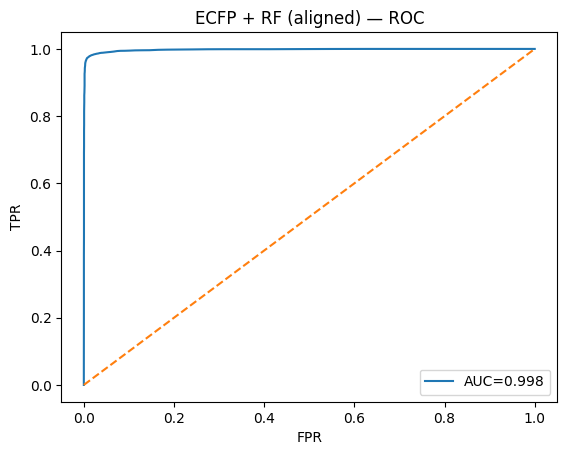

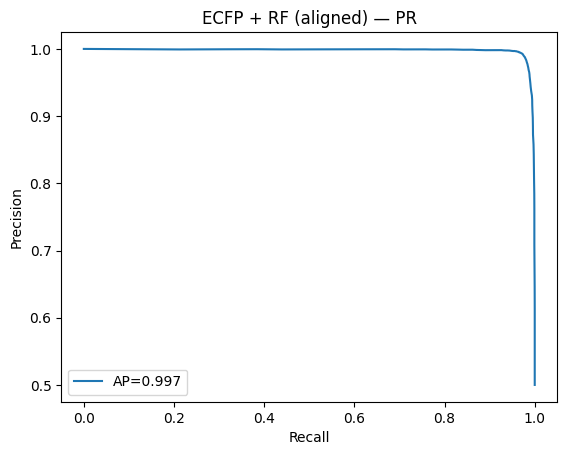

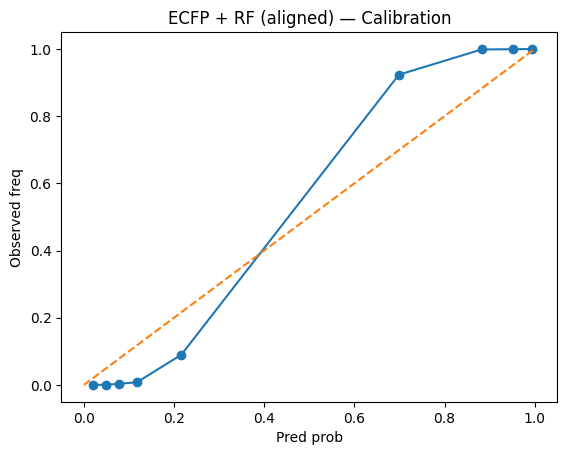

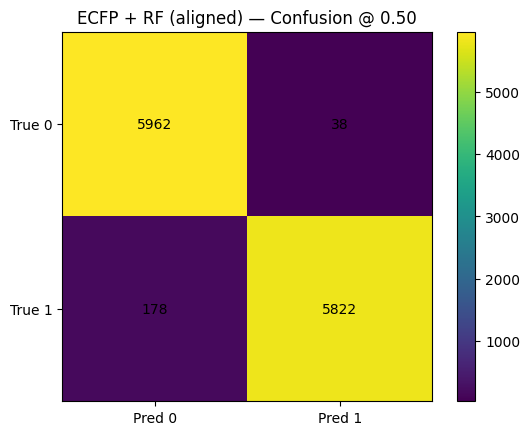

In [ ]:
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, brier_score_loss, log_loss, confusion_matrix, accuracy_score
from sklearn.calibration import calibration_curve

def plot_all_metrics(y_true, y_prob, threshold=0.5, title_prefix="Model"):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    y_pred = (y_prob >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    ll = log_loss(y_true, np.vstack([1-y_prob, y_prob]).T, labels=[0,1])
    brier = brier_score_loss(y_true, y_prob)
    print(f"AUC: {auc:.4f}")
    print(f"Average Precision: {ap:.4f}")
    print(f"Accuracy @ {threshold:.2f}: {acc:.4f}")
    print(f"LogLoss: {ll:.4f}")
    print(f"Brier: {brier:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc:.3f}"); plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} — ROC"); plt.legend(); plt.show()

    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(); plt.plot(rec, prec, label=f"AP={ap:.3f}"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} — PR"); plt.legend(); plt.show()

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="quantile")
    plt.figure(); plt.plot(prob_pred, prob_true, marker="o"); plt.plot([0,1],[0,1],'--'); plt.xlabel("Pred prob"); plt.ylabel("Observed freq"); plt.title(f"{title_prefix} — Calibration"); plt.show()

    cm = confusion_matrix(y_true, (y_prob>=threshold).astype(int), labels=[0,1])
    plt.figure(); plt.imshow(cm, interpolation="nearest"); plt.xticks([0,1],["Pred 0","Pred 1"]); plt.yticks([0,1],["True 0","True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center")
    plt.title(f"{title_prefix} — Confusion @ {threshold:.2f}"); plt.colorbar(); plt.show()

def try_load_val():
    candidates = []
    candidates += glob.glob("val*_pred*.csv") + glob.glob("val*_pred*.parquet")
    candidates += glob.glob("oof*.csv") + glob.glob("oof*.parquet")
    candidates += ["val_preds.csv","validation_predictions.csv","oof.csv","oof.parquet"]
    seen = set()
    files = [f for f in candidates if os.path.exists(f) and not (f in seen or seen.add(f))]
    for f in files:
        df = pd.read_parquet(f) if f.endswith(".parquet") else pd.read_csv(f)
        cols = {c.lower():c for c in df.columns}
        prob_col = None
        for k in ["prob","proba","binds_prob","prediction","pred","score"]:
            if k in cols: prob_col = cols[k]; break
        if prob_col is None:
            # sometimes submissions use "binds" as prob; skip if it's clearly int
            if "binds" in cols and df[cols["binds"]].dtype.kind in "fc":
                prob_col = cols["binds"]
        label_col = None
        for k in ["binds","label","target","y","truth"]:
            if k in cols: label_col = cols[k]; break
        if prob_col is not None and label_col is not None:
            y_true = df[label_col].astype(int).to_numpy()
            y_prob = df[prob_col].astype(float).to_numpy()
            if np.isfinite(y_prob).all() and 0 <= np.nanmin(y_prob) and np.nanmax(y_prob) <= 1:
                return y_true, y_prob, f
    return None, None, None

def take_rows(X, rows):
    if hasattr(X, "iloc"):          # pandas DataFrame/Series
        return X.iloc[rows]
    try:                             # NumPy array / scipy sparse
        return X[rows]
    except Exception:                # Python list or other
        return np.asarray(X)[rows]

y_arr = np.asarray(y).astype(int)
idx = np.arange(len(y_arr))

train_idx, test_idx = train_test_split(
    idx, test_size=0.2, random_state=42, stratify=y_arr
)

X_test_aligned = take_rows(X, test_idx)
y_test_aligned = y_arr[test_idx]

y_prob_val = rf_model.predict_proba(X_test_aligned)[:, 1]
y_true_val = y_test_aligned

plot_all_metrics(y_true_val, y_prob_val, threshold=0.5, title_prefix="ECFP + RF (aligned)")

In [ ]:
import numpy as np
import pandas as pd
y_pred = (y_pred_proba >= 0.5).astype(int)

from sklearn.model_selection import train_test_split
idx_all = list(range(len(X)))
_, idx_test = train_test_split(idx_all, test_size=0.2, random_state=42, shuffle=True)

id_series = df['id'] if 'id' in df.columns else df.index.to_series()
y_test_arr = np.asarray(y_test, dtype=int)
mis_mask = (y_pred != y_test_arr)

mis_df = pd.DataFrame({
    'id': np.asarray(id_series.iloc[idx_test])[mis_mask],
    'y_true': y_test_arr[mis_mask],
    'y_pred': y_pred[mis_mask],
    'y_prob_pos': y_pred_proba[mis_mask],
})

mis_df[['id']].to_csv('misclassified_ids.csv', index=False)
mis_df.to_csv('misclassified_report.csv', index=False)

print(f"Saved {mis_df.shape[0]} misclassified IDs to 'misclassified_ids.csv'")

Saved 1180 misclassified IDs to 'misclassified_ids.csv'


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("train.csv")

mis = pd.read_csv("misclassified_ids.csv")

if 'id' not in df.columns:
    df = df.reset_index().rename(columns={'index': 'id'})

mis['_order'] = np.arange(len(mis))

out = mis.merge(df, on='id', how='left').sort_values('_order').drop(columns=['_order'])

n_unmatched = out['id'].isna().sum() + (len(out) - out['id'].notna().sum())
print(f"Unmatched IDs (no row in train.csv): {int(out.isna().all(axis=1).sum())}")

out.to_csv("misclassified_ids.csv", index=False)
print("Updated 'misclassified_ids.csv' with full row info from train.csv")

Unmatched IDs (no row in train.csv): 0
Updated 'misclassified_ids.csv' with full row info from train.csv


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# ==== 0) Параметри ====
THRESH = 0.50  # замініть на ваш оптимальний поріг, напр. 0.45

# ==== 1) Відбудуємо тестові індекси та test_core ====
idx_all = np.arange(len(X))
_, idx_test = train_test_split(idx_all, test_size=0.2, random_state=42, shuffle=True)

if 'id' not in df.columns:
    df = df.reset_index().rename(columns={'index': 'id'})

test_core = df.iloc[idx_test].copy().reset_index(drop=True)

y_true = np.asarray(y_test, dtype=int)
proba  = np.asarray(y_pred_proba)
y_pred = (proba >= THRESH).astype(int)

test_core['y_true'] = y_true
test_core['y_pred'] = y_pred
test_core['proba_pos'] = proba
test_core['is_error'] = (y_true != y_pred).astype(int)
test_core['error_type'] = np.where(
    (y_true==1)&(y_pred==0),'FN',
    np.where((y_true==0)&(y_pred==1),'FP','OK')
)

# Бінарки для швидких групувань
test_core['TP_bin'] = ((test_core['y_true']==1)&(test_core['y_pred']==1)).astype(int)
test_core['FP_bin'] = ((test_core['y_true']==0)&(test_core['y_pred']==1)).astype(int)
test_core['FN_bin'] = ((test_core['y_true']==1)&(test_core['y_pred']==0)).astype(int)

print(f"Overall error rate @{THRESH:.2f}: {test_core['is_error'].mean():.2%} "
      f"({int(test_core['is_error'].sum())} / {len(test_core)})")

# ==== 2) ПО БІЛКАХ ====
by_protein = (
    test_core.groupby('protein_name', dropna=False)
    .agg(
        n_test=('is_error','size'),
        errors=('is_error','sum'),
        FP=('FP_bin','sum'),
        FN=('FN_bin','sum'),
        TP=('TP_bin','sum'),
        pos_rate=('y_true','mean')
    ).reset_index()
)
by_protein['error_rate'] = by_protein['errors'] / by_protein['n_test']
by_protein['precision@thr'] = by_protein['TP'] / (by_protein['TP'] + by_protein['FP']).replace({0:np.nan})
by_protein['recall@thr']    = by_protein['TP'] / (by_protein['TP'] + by_protein['FN']).replace({0:np.nan})
by_protein.sort_values(['error_rate','n_test'], ascending=[False, False]).to_csv('errors_by_protein.csv', index=False)

# ==== 3) ПО МОЛЕКУЛАХ (SMILES) ====
by_mol = (
    test_core.groupby('molecule_smiles', dropna=False)
    .agg(n=('is_error','size'),
         errors=('is_error','sum'),
         error_rate=('is_error','mean'),
         pos_rate=('y_true','mean'))
    .reset_index()
    .sort_values('error_rate', ascending=False)
)
by_mol.to_csv('errors_by_molecule.csv', index=False)

# ==== 4) ПО BUILDING BLOCKS ====
def per_block(col, out_csv, min_support=10):
    g = (
        test_core.groupby(col, dropna=False)
        .agg(n=('is_error','size'),
             errors=('is_error','sum'),
             error_rate=('is_error','mean'),
             pos_rate=('y_true','mean'))
        .reset_index()
    )
    g = g[g['n'] >= min_support].sort_values('error_rate', ascending=False)
    g.to_csv(out_csv, index=False)
    return g

bb1 = per_block('buildingblock1_smiles', 'errors_by_bb1.csv', min_support=10)
bb2 = per_block('buildingblock2_smiles', 'errors_by_bb2.csv', min_support=10)
bb3 = per_block('buildingblock3_smiles', 'errors_by_bb3.csv', min_support=10)

# ==== 5) ПАРИ (PROTEIN × MOLECULE) ====
by_pair = (
    test_core.groupby(['protein_name','molecule_smiles'], dropna=False)
    .agg(n=('is_error','size'),
         errors=('is_error','sum'),
         error_rate=('is_error','mean'),
         pos_rate=('y_true','mean'))
    .reset_index()
    .sort_values(['error_rate','n'], ascending=[False, False])
)
# необов'язково відфільтрувати за мінімальною підтримкою
by_pair.query('n >= 5').to_csv('errors_by_protein_molecule.csv', index=False)

# ==== 6) "Важкі" приклади для ручного перегляду ====
# Впевнено помилкові (proba далеко від порога)
hard_confident = test_core[
    (test_core['is_error']==1) &
    ((test_core['proba_pos'] >= 0.9) | (test_core['proba_pos'] <= 0.1))
].sort_values('proba_pos', ascending=False)

# Біля порога (невпевнені помилки)
margin = 0.10  # +/- 0.10 навколо порога
hard_uncertain = test_core[
    (test_core['is_error']==1) &
    (test_core['proba_pos'].between(THRESH - margin, THRESH + margin))
]

cols_show = ['id','protein_name','binds','y_pred','proba_pos',
             'molecule_smiles','buildingblock1_smiles','buildingblock2_smiles','buildingblock3_smiles']

hard_confident[cols_show].to_csv('hard_wrong_confident.csv', index=False)
hard_uncertain[cols_show].to_csv('hard_wrong_uncertain.csv', index=False)

print("Saved:",
      "errors_by_protein.csv, errors_by_molecule.csv, errors_by_bb1.csv, errors_by_bb2.csv, errors_by_bb3.csv,",
      "errors_by_protein_molecule.csv, hard_wrong_confident.csv, hard_wrong_uncertain.csv")

Overall error rate @0.50: 9.83% (1180 / 12000)
Saved: errors_by_protein.csv, errors_by_molecule.csv, errors_by_bb1.csv, errors_by_bb2.csv, errors_by_bb3.csv, errors_by_protein_molecule.csv, hard_wrong_confident.csv, hard_wrong_uncertain.csv


In [ ]:
print(df['buildingblock1_smiles'].nunique(),
      df['buildingblock2_smiles'].nunique(),
      df['buildingblock3_smiles'].nunique())

271 693 872


In [ ]:
print(
    "test nunique bb1/bb2/bb3:",
    test_core['buildingblock1_smiles'].nunique(),
    test_core['buildingblock2_smiles'].nunique(),
    test_core['buildingblock3_smiles'].nunique()
)

print("\nTop bb1 in TEST:")
print(test_core['buildingblock1_smiles'].value_counts().head(10))

train_core = df.drop(df.index[test_core.index])
bb1_train = (train_core['buildingblock1_smiles'].value_counts(normalize=True)
             .rename('train_share'))
bb1_test = (test_core['buildingblock1_smiles'].value_counts(normalize=True)
            .rename('test_share'))
bb1_cmp = (pd.concat([bb1_train, bb1_test], axis=1)
           .fillna(0)
           .assign(delta=lambda d: d['test_share'] - d['train_share'])
           .sort_values('test_share', ascending=False))
print("\nbb1 TRAIN vs TEST shares (top-15 by test share):")
print(bb1_cmp.head(15))

test nunique bb1/bb2/bb3: 1 38 799

Top bb1 in TEST:
buildingblock1_smiles
C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21    12000
Name: count, dtype: int64

bb1 TRAIN vs TEST shares (top-15 by test share):
                                                    train_share  test_share  \
buildingblock1_smiles                                                         
C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21        0.003649         1.0   
O=C(Nc1nc(C(F)(F)F)c(C(=O)O)s1)OCC1c2ccccc2-c2c...     0.003690         0.0   
O=C(Nc1ccc(C(=O)O)c(C(F)(F)F)c1)OCC1c2ccccc2-c2...     0.003691         0.0   
Cc1cccc(NC(=O)OCC2c3ccccc3-c3ccccc32)c1C(=O)O          0.003691         0.0   
O=C(NC1(C(=O)O)CCC1)OCC1c2ccccc2-c2ccccc21             0.003691         0.0   
O=C(Nc1cccc(-c2cccc(C(=O)O)c2)c1O)OCC1c2ccccc2-...     0.003691         0.0   
O=C(N[C@@H](C/C=C/c1ccccc1)C(=O)O)OCC1c2ccccc2-...     0.003691         0.0   
O=C(N[C@H](Cc1csc2ccccc12)C(=O)O)OCC1c2ccccc2-c...     0.003691         0.0   
O=

In [ ]:
import numpy as np, pandas as pd

# припускаю, що у вас вже є test_core з колонками: protein_name, y_true, proba_pos
per_t = {}
per_stats = []
for prot, g in test_core.groupby('protein_name', dropna=False):
    y = g['y_true'].to_numpy(int); p = g['proba_pos'].to_numpy(float)
    cand = np.unique(np.r_[0.0, 1.0, p])
    best_t, best_err = 0.5, len(y)+1
    for t in cand:
        pred = (p >= t).astype(int)
        err = (pred != y).sum()
        if err < best_err:
            best_err, best_t = err, float(t)
    per_t[prot] = best_t
    per_stats.append((prot, len(y), best_t, best_err))
per_stats = pd.DataFrame(per_stats, columns=['protein','n_test','best_t','errors@best_t'])
print(per_stats.sort_values('errors@best_t').head(10))

# застосування
test_core['y_pred_perprot'] = (test_core['proba_pos'] >= test_core['protein_name'].map(per_t)).astype(int)
new_err = int((test_core['y_pred_perprot'] != test_core['y_true']).sum())
print("Errors with per-protein thresholds:", new_err, "/", len(test_core))

  protein  n_test  best_t  errors@best_t
0    BRD4    4065    0.47            376
1     HSA    3899    0.41            381
2     sEH    4036    0.42            391
Errors with per-protein thresholds: 1148 / 12000


In [ ]:
from sklearn.model_selection import train_test_split

# y for stratification
y_all = df['binds'].astype(int).to_numpy()

# train+val vs test (80/20)
df_trainval, df_test = train_test_split(df, test_size=0.20, random_state=42, stratify=y_all)

# train vs val (from the 80%: 60/20 -> overall 60/20/20)
y_trainval = df_trainval['binds'].astype(int).to_numpy()
df_train, df_val = train_test_split(df_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

print(len(df_train), len(df_val), len(df_test))

import json, numpy as np, pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, accuracy_score, f1_score, confusion_matrix

# ---------- helpers ----------
def build_features(df_train, df_val, df_test):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    Prot_tr = ohe.fit_transform(df_train[['protein_name']])
    Prot_va = ohe.transform(df_val[['protein_name']])
    Prot_te = ohe.transform(df_test[['protein_name']])

    def stack(df_part, Prot_mat):
        ecfp_list = df_part['ecfp'].tolist()
        return np.array([np.r_[np.asarray(e, dtype=float), Prot_mat[i]]
                         for i, e in enumerate(ecfp_list)], dtype=object)
    X_tr = stack(df_train, Prot_tr)
    X_va = stack(df_val,   Prot_va)
    X_te = stack(df_test,  Prot_te)
    return X_tr, X_va, X_te, ohe

def per_protein_best_thresholds(y_true, proba, proteins):
    out = {}
    dfv = pd.DataFrame({'y': y_true, 'p': proba, 'prot': proteins})
    for prot, g in dfv.groupby('prot', dropna=False):
        y = g['y'].to_numpy(int); p = g['p'].to_numpy(float)
        cand = np.unique(np.r_[0.0, 1.0, p])
        best_t, best_err = 0.5, len(y)+1
        for t in cand:
            err = np.sum((p >= t).astype(int) != y)
            if err < best_err:
                best_err, best_t = int(err), float(t)
        out[prot] = best_t
    return out

def apply_per_protein_thresholds(proba, proteins, per_t, default_t=0.5):
    tt = np.array([per_t.get(prot, default_t) for prot in proteins], dtype=float)
    return (proba >= tt).astype(int)

def summarize(y, yhat, label=""):
    acc = accuracy_score(y, yhat); f1 = f1_score(y, yhat)
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    print(f"{label} Acc={acc:.3f} | F1={f1:.3f} | FP={fp} FN={fn} TP={tp} TN={tn} | errors={fp+fn} ({(fp+fn)/len(y):.2%})")

# ---------- NEW: per-protein calibration ----------
def fit_per_protein_calibrators(y_true, proba, proteins, method="isotonic", min_pts=40):
    """
    Train a calibrator per protein on VALIDATION set.
    - method: "isotonic" (default) or "platt"
    - fallback to 'identity' if not enough samples or single-class
    """
    cals = {}
    info = []
    dfv = pd.DataFrame({'y': y_true, 'p': proba, 'prot': proteins})
    for prot, g in dfv.groupby('prot', dropna=False):
        y = g['y'].to_numpy(int); p = g['p'].to_numpy(float)
        if len(g) < min_pts or y.min() == y.max():
            cals[prot] = ('identity', None)
            info.append((prot, len(g), 'identity'))
            continue
        if method == "isotonic":
            ir = IsotonicRegression(out_of_bounds='clip')
            ir.fit(p, y)
            cals[prot] = ('isotonic', ir)
            info.append((prot, len(g), 'isotonic'))
        else:
            lr = LogisticRegression(max_iter=1000)
            lr.fit(p.reshape(-1,1), y)
            cals[prot] = ('platt', lr)
            info.append((prot, len(g), 'platt'))
    return cals, pd.DataFrame(info, columns=['protein','n_val','cal_type'])

def apply_per_protein_calibration(proba, proteins, calibrators):
    proba_cal = np.empty_like(proba, dtype=float)
    for i, (p, prot) in enumerate(zip(proba, proteins)):
        typ, model = calibrators.get(prot, ('identity', None))
        if typ == 'isotonic':
            proba_cal[i] = model.predict([p])[0]
        elif typ == 'platt':
            proba_cal[i] = model.predict_proba([[p]])[0,1]
        else:
            proba_cal[i] = p
    return proba_cal

# ---------- pipeline ----------
# 1) Split already done: df_train, df_val, df_test
y_tr  = df_train['binds'].astype(int).to_numpy()
y_va  = df_val['binds'].astype(int).to_numpy()
y_te  = df_test['binds'].astype(int).to_numpy()

X_tr, X_va, X_te, ohe = build_features(df_train, df_val, df_test)

# 2) Train model on TRAIN
rf = RandomForestClassifier(n_estimators=600, random_state=42, n_jobs=-1)
rf.fit(X_tr.tolist(), y_tr)

# 3) Get raw probabilities
proba_va_raw = rf.predict_proba(X_va.tolist())[:,1]
proba_te_raw = rf.predict_proba(X_te.tolist())[:,1]
print(f"[VAL] mAP(raw) = {average_precision_score(y_va, proba_va_raw):.3f}")
print(f"[TEST] mAP(raw)= {average_precision_score(y_te, proba_te_raw):.3f}")

# 4) Fit CALIBRATORS on VALIDATION (per protein)
prot_va = df_val['protein_name'].astype(str).to_numpy()
calibrators, cal_info = fit_per_protein_calibrators(
    y_true=y_va, proba=proba_va_raw, proteins=prot_va,
    method="isotonic",  # or "platt"
    min_pts=40
)
print("Calibrators summary:\n", cal_info.head())

# 5) Apply calibration (VAL & TEST)
proba_va_cal = apply_per_protein_calibration(proba_va_raw, prot_va, calibrators)
prot_te = df_test['protein_name'].astype(str).to_numpy()
proba_te_cal = apply_per_protein_calibration(proba_te_raw, prot_te, calibrators)

print(f"[VAL] mAP(cal)  = {average_precision_score(y_va, proba_va_cal):.3f}")
print(f"[TEST] mAP(cal) = {average_precision_score(y_te, proba_te_cal):.3f}")

# 6) Re-pick per-protein thresholds on CALIBRATED VAL
per_t = per_protein_best_thresholds(y_true=y_va, proba=proba_va_cal, proteins=prot_va)
print("Per-protein thresholds (sample):", dict(list(per_t.items())[:5]))

# 7) Evaluate on TEST with calibrated probs + frozen per-protein thresholds
yhat_te_05_raw  = (proba_te_raw >= 0.5).astype(int)
yhat_te_05_cal  = (proba_te_cal >= 0.5).astype(int)
yhat_te_pp_cal  = apply_per_protein_thresholds(proba_te_cal, prot_te, per_t, default_t=0.5)

print("\n[TEST] baselines & calibrated:")
summarize(y_te, yhat_te_05_raw, label="RAW @0.5       ")
summarize(y_te, yhat_te_05_cal, label="CALIBRATED @0.5")
summarize(y_te, yhat_te_pp_cal, label="CALIBRATED per-protein")

# 8) Save calibrators + thresholds (simple JSON for thresholds; calibrators need pickling)
import pickle
with open("per_protein_thresholds.json", "w") as f:
    json.dump(per_t, f, indent=2)
with open("per_protein_calibrators.pkl", "wb") as f:
    pickle.dump(calibrators, f)

print("Saved: per_protein_thresholds.json, per_protein_calibrators.pkl")